<a href="https://colab.research.google.com/github/syedsaifhasan/Document-Classification/blob/master/Document_Classification_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In this step, we imported and installed all the necessary libraries needed to perform Multi-Label Document Classification.

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('reuters')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...


True

In [0]:
import os
import sys
import numpy as np

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Input
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import average
from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Initializing Parameters

We initialied and defined the parameters of our document classifier in this step.

In [0]:
MAX_SEQUENCE_LENGTH = 1335
MAX_NUM_WORDS = 1335
EMBEDDING_DIM = 300

subset = ['potato', 'rand', 'wpi', 'wheat', 'yen']

n_classes = 90
labels = reuters.categories()
mlb = MultiLabelBinarizer(labels)

# Preparing the Dataset

We created three subsets which are training, testing and validation sets. The validation set was prepared by splitting the training set in 9:1 ratio.

In [0]:
# LOAD DATASET

# Function to load dataset
def load_set(set_name):
  # Load Training Data
  data_ids =  list(filter(lambda x: x.startswith(set_name), reuters.fileids()))
  data = [reuters.raw(doc_id) for doc_id in data_ids]
  labels = [reuters.categories(doc_id) for doc_id in data_ids]
  return data, labels

# Load Training Set and Labels
train_data, train_labels = load_set('training/')

# Load Validation Set and Labels
split = round(len(train_data)*0.90)

validation_data = train_data[split+1:]
validation_labels = train_labels[split+1:]

train_data = train_data[:split]
train_labels = train_labels[:split]

# Load Testing Set and Labels
test_data, test_labels = load_set('test/')

print ('Dataset Loaded...')
print ('Training Data: {} Samples, {} Labels'.format(len(train_data), len(train_labels)))
print ('Validation Data: {} Samples, {} Labels'.format(len(validation_data), len(validation_labels)))
print ('Testing Data: {} Samples, {} Labels'.format(len(test_data), len(test_labels)))

Dataset Loaded...
Training Data: 6992 Samples, 6992 Labels
Validation Data: 776 Samples, 776 Labels
Testing Data: 3019 Samples, 3019 Labels


The subsets were transformed into their respective encodings and their dictionaries were also created.

In [0]:
# ENCODE TEXT AND LABELS

print('Encoding Data....')

def encode(data, labels, tokenizer=None):
  # Encode Text
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  # Encode Labels
  labels = mlb.fit_transform(labels)
  # Create Dictsizeionary
  dictionary = tokenizer.word_index
  return data, labels, dictionary

# FETCH DATA, LABELS, DICTIONARIES
train_data, train_labels, train_dictionary = encode(train_data, train_labels)
validation_data, validation_labels, validation_dictionary = encode(validation_data, validation_labels)
test_data, test_labels, test_dictionary = encode(test_data, test_labels)

actual = test_labels

print ("Data Encoded...\n")

print ("Dictionaries Loaded...")
print ('Training Dictionary: {} Words'.format(len(train_dictionary)))
print ('Validation Dictionary: {} Words'.format(len(validation_dictionary)))
print ('Testing Dictionary: {} Words'.format(len(test_dictionary)))

Encoding Data....
(6992, 1335) (6992, 90)
(3019, 1335) (3019, 90)
(776, 1335) (776, 90)
Data Encoded...

Dictionaries Loaded...
Training Dictionary: 26351 Words
Validation Dictionary: 8918 Words
Testing Dictionary: 17774 Words


# Creating Embedding Matrix

We loaded both the word embedding models and created their large emdbedding matrices of all the words present in the model.

In [0]:
print('Preparing embedding matrix....\n')

print ('Loading the pretrained models...')

pretrained_model_paths = {'glove':'glove.42B.300d.txt','fasttext':'fasttext-wiki-news-300d-1M-subword.vec'}
embeddings_indexes = {}

for model, path in pretrained_model_paths.items():
  embeddings_index = {}
  print ("Loading {} model's pretrained embeddings...".format(model))
  with open('/content/drive/My Drive/sentiment_classification/' + path) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  embeddings_indexes[model] = embeddings_index
  print('Found {} word vectors in this model.'.format(len(embeddings_index)))

Preparing embedding matrix....

Loading the pretrained models...
Loading glove model's pretrained embeddings...
Found 1917494 word vectors in this model.
Loading fasttext model's pretrained embeddings...
Found 999995 word vectors in this model.


In this process, we prepared two embedding matrices for each model with respect to the training data. 

To do this, we first initialized a 2D matrix of size (Number of words, word vector size) with zeros and updated each row with the word vectors fetched from the large embedding matrix. The process is repeated for both the models.

In [0]:
num_words = min(MAX_NUM_WORDS, len(train_dictionary) + 1)
embedding_matrices = {}

for model, embedding_index in embeddings_indexes.items():
  print ("Preparing {} model's embedding matrix...".format(model))
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in train_dictionary.items():
      if i >= MAX_NUM_WORDS:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  print ('Embedding Matrix Created of size', embedding_matrix.shape)
  embedding_matrices[model] = embedding_matrix

Preparing glove model's embedding matrix...
Embedding Matrix Created of size (1335, 300)
Preparing fasttext model's embedding matrix...
Embedding Matrix Created of size (1335, 300)


# Creating the Neural Network

In this step we created the evaluation functions for multi-label classification.

In [0]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def accuracy(y_true, y_pred):
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    accuracy = (true_positives) / (possible_positives + predicted_positives + K.epsilon())
    return accuracy

def f1(y_true, y_pred):
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r))
    return f1

We created an ensemble model using two branches of neural networks. The structure of the neural network is included in the seminar paper.

In [0]:
print ('Building Model...')

def get_model(embedding_model):
  print (embedding_model.shape)
  inputs = Input(shape=(2380,))
  embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_model),
                              input_length=1335,
                              trainable=False)
  model = Sequential()
  model.add(embedding_layer)
  # model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='sigmoid'))
  print(model.summary())

  return model

fast_text_model = get_model(embedding_matrices['fasttext'])
glove_model = get_model(embedding_matrices['glove'])

inputs = Input(shape=(1335,))
y1 = fast_text_model(inputs)
y2 = glove_model(inputs)
outputs = average([y1, y2])
ensemble_model = Model(inputs=inputs, outputs=outputs)

ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1])

Building Model...
(1335, 300)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1335, 300)         400500    
_________________________________________________________________
flatten_1 (Flatten)          (None, 400500)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102528256 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 9

# Training the neural network

We trained the neural network in 4 epochs.

In [0]:
print('Training Started...\n')
history  = ensemble_model.fit(train_data, train_labels,
          batch_size=128,
          epochs=4, shuffle=True,
          validation_data=(validation_data, validation_labels))

Training Started...



Train on 6992 samples, validate on 776 samples
Epoch 1/4


6992/6992 [==============================] - 17s 2ms/step - loss: 0.1294 - accuracy: 0.1149 - precision: 0.5758 - recall: 0.1558 - f1: nan - val_loss: 0.0518 - val_accuracy: 0.0528 - val_precision: 0.8022 - val_recall: 0.0569 - val_f1: 0.1056
Epoch 2/4
6992/6992 [==============================] - 6s 807us/step - loss: 0.0452 - accuracy: 0.1712 - precision: 0.8545 - recall: 0.2148 - f1: 0.3424 - val_loss: 0.0453 - val_accuracy: 0.1140 - val_precision: 0.9089 - val_recall: 0.1315 - val_f1: 0.2280
Epoch 3/4
6992/6992 [==============================] - 6s 811us/step - loss: 0.0367 - accuracy: 0.1796 - precision: 0.9261 - recall: 0.2241 - f1: 0.3592 - val_loss: 0.0438 - val_accuracy: 0.1480 - val_precision: 0.8845 - val_recall: 0.1800 - val_f1: 0.2960
Epoch 4/4
6992/6992 [==============================] - 6s 811us/step - loss: 0.0308 - accuracy: 0.1920 - precision: 0.9545 - recall: 0.2413 - f1: 0.3841 - val_lo

# Evaluating the model

We evaluated the model in this step.

In [0]:
print ('Evaluating Model...')
score, test_acc, test_precision, test_recall, test_f1 = ensemble_model.evaluate(test_data, test_labels,
                            batch_size=128)
print('\nTest score:', score)
print('Test accuracy:', round(test_acc*100, 2))
print('Test precision:', round(test_precision*100, 2))
print('Test recall:', round(test_recall*100, 2))
print('Test F1:', round(test_f1*100, 2))

Evaluating Model...
3019/3019 [==============================] - 1s 231us/step

Test score: 0.049000892321739264
Test accuracy: 13.76
Test precision: 82.03
Test recall: 17.28
Test F1: 27.52


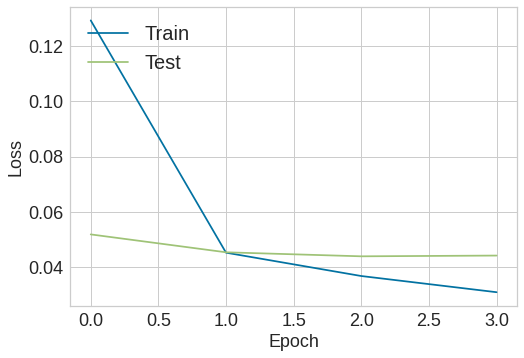

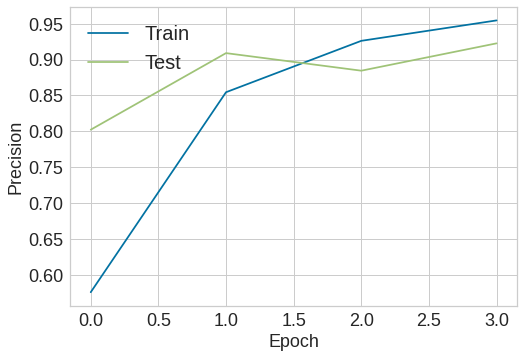

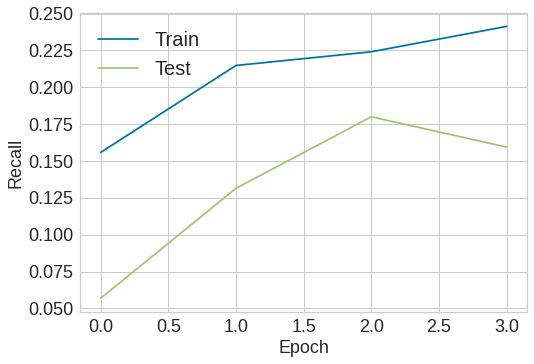

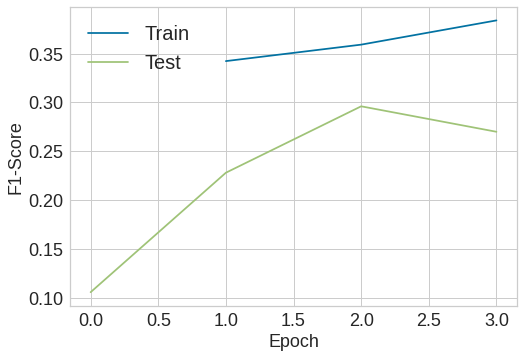

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

In [0]:
print ("Macro Recall: ", np.mean(history.history['val_recall']))
# print ("Macro Accuracy: ", np.mean(history.history['val_accuracy_metric']))
print ("Macro Precision: ", np.mean(history.history['val_precision']))
print ("Macro F1: ", np.mean(history.history['val_f1']))

Macro Recall:  0.1319456458014926
Macro Precision:  0.8795550090750468
Macro F1:  0.22490706548248368
